In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import json # for saving data
import pickle
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar

ModuleNotFoundError: No module named 'pandas'

# Set up environment

In [3]:
# Set seeds for reproducibility
# https://pytorch.org/docs/stable/notes/randomness.html
np.random.seed(20221123)
torch.manual_seed(20221123)
random.seed(20221123)

# Use GPU if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

################################# Data Directory #######################################
try:
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = os.path.join('/content','drive','MyDrive','BsC_Project_Data','T8Colored')
except:
    data_dir = os.path.join('TFR_plots','T8Colored')
########################################################################################

DRIVE_RES_DIR = os.path.join('/content','drive','MyDrive','BsC_Project_Data','Results')
EPOCHS = 25
BATCH_SIZE = 8

In [4]:
# Image transform, perhaps include data augmentation, NOTE: transform is currently applied to all data, so NO augment
transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Imagenet specific normalization
        ])

# Test Subjects
Subjects = ["Subject"+str(i) for i in range(10,16)]

all_image_datasets = {subject: datasets.ImageFolder(os.path.join(data_dir, subject), #Transform applied to all data!!
                                          transform) for subject in Subjects}

# Data splitting, different for intra- and inter-subject model.
########################## Inter subject, Subj10 test #####################
TestSubj = Subjects[0]
del Subjects[0]
train_set = torch.utils.data.ConcatDataset([all_image_datasets[subject] for subject in Subjects])
val_set = all_image_datasets[TestSubj]
###########################################################################
image_datasets = {"train":train_set, "val":val_set}

# Prepare data loader
dataloaders = {phase: torch.utils.data.DataLoader(image_datasets[phase], batch_size=BATCH_SIZE,
                                    shuffle=True, num_workers=4) for phase in ["train", "val"]}

dataset_sizes = {phase: len(image_datasets[phase]) for phase in ["train", "val"]}

#class_names = image_datasets["train"].classes
class_names = val_set.classes

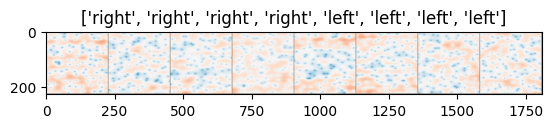

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders, dataset_sizes):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    # Store results
    lossvec = {"train":[], "val":[]} 
    accvec = {"train":[], "val":[]}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            lossvec[phase].append(epoch_loss)
            accvec[phase].append(epoch_acc.item())
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, lossvec, accvec

In [7]:
def GenPlot(epochs,loss,acc,name):
    X = range(epochs)
    fig,ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].plot(X,loss["train"],label="train", color="blue")
    ax[0].plot(X,loss["val"],label="val", color="red")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    ax[1].plot(X,acc["train"],label="train", color="blue")
    ax[1].plot(X,acc["val"],label="val", color="red")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    fig.suptitle(name,fontsize=16)
    plt.subplots_adjust(wspace=0.2)

In [8]:
def saveResults(loss,acc,name,path,model = None):
    partialname = os.path.join(path,name)
    resDict = {name:{"loss":loss,"acc":acc}}
    with open(partialname+".json", 'w', encoding='utf-8') as f:
        json.dump(resDict, f, ensure_ascii=False, indent=4)
    if model:
        torch.save(model.state_dict(), partialname+".pth")

# Train last Block, freeze rest

In [9]:
model_base = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')

for param in model_base.parameters():
    param.requires_grad = False

num_ftrs = model_base.fc.in_features
# Set last deep layer as trainable
"""
model_conv.layer4[1].conv1 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model_conv.layer4[1].bn1 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
model_conv.layer4[1].conv2 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model_conv.layer4[1].bn2 = nn.Dropout(p=0.5,inplace=True)

"""
#for param in model_conv.layer3[1].parameters():
#    param.required_grad = True

for param in model_base.layer4.parameters():
    param.required_grad = True


# Create classifier layer with dropout for overfit prevention
model_base.fc = nn.Sequential(
    nn.Dropout(p=0.5,inplace=True),
    nn.Linear(num_ftrs, 2) 
)

model_conv = model_base.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(filter(lambda p: p.requires_grad, model_conv.parameters()), lr=0.001, momentum=0.9, weight_decay=5e-2)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_base, loss_base, acc_base = train_model(model_base, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=EPOCHS, dataloaders=dataloaders, dataset_sizes=dataset_sizes)

Epoch 0/24
----------


KeyboardInterrupt: 

In [ ]:
# Save results, should just do something with pickle here as well
name = "PT_ResNet_Freeze"
saveResults(loss_base,acc_base,name,DRIVE_RES_DIR)
# Save Model
with open(os.path.join(DRIVE_RES_DIR,"ResNetInter.pkl"), "wb") as f:
    pickle.dump(model_base,f)

In [ ]:
GenPlot(EPOCHS,loss_base,acc_base,"Block-Trained ResNet18")

# Train last FC only

In [ ]:
# Set seeds for reproducibility
# https://pytorch.org/docs/stable/notes/randomness.html
np.random.seed(20221123)
torch.manual_seed(20221123)
random.seed(20221123)

########################## Intra subject, Subject 10 ######################
dataset = all_image_datasets["Subject10"]
train_set, val_set = torch.utils.data.random_split(dataset,[292,60])

image_datasets = {"train":train_set, "val":val_set}

# Prepare data loader
dataloaders = {phase: torch.utils.data.DataLoader(image_datasets[phase], batch_size=BATCH_SIZE,
                                    shuffle=True, num_workers=2) for phase in ["train", "val"]}

dataset_sizes = {phase: len(image_datasets[phase]) for phase in ["train", "val"]}


In [ ]:
# Here we train a chosen section of the network architecture.
with open(os.path.join(DRIVE_RES_DIR,"ResNetInter.pkl"), "rb") as f:
  model_base = pickle.load(f)

for param in model_base.parameters():
    param.requires_grad = False

# Unfreeze some weights
model_base.layer4[1].conv1 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model_base.layer4[1].bn1 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
model_base.layer4[1].conv2 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model_base.layer4[1].bn2 = nn.Dropout(p=0.8,inplace=True)

# Create classifier layer with dropout for overfit prevention
model_base.fc = nn.Sequential(
    nn.Dropout(p=0.8,inplace=True),
    nn.Linear(num_ftrs, 2) 
)

model_fc = model_base.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_fc = optim.SGD(filter(lambda p: p.requires_grad, model_fc.parameters()), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_fc, step_size=7, gamma=0.1)

In [ ]:
model_fc, loss_fc, acc_fc = train_model(model_base, criterion, optimizer_fc, exp_lr_scheduler,
                       num_epochs=EPOCHS, dataloaders=dataloaders, dataset_sizes=dataset_sizes)

In [ ]:
#name = "GC3_Tune_FC"
#saveResults(loss_fc,acc_fc,name,DRIVE_RES_DIR)

with open(os.path.join(DRIVE_RES_DIR,"ResNetIntra.pkl"), "wb") as f:
    pickle.dump(model_fc,f)

with open(os.path.join(DRIVE_RES_DIR,"ResNetValData.pkl"), "wb") as f:
    pickle.dump(val_set,f)

In [ ]:
GenPlot(EPOCHS,loss_fc,acc_fc,"Pre-Trained ResNet18 Tune FC")

# McNemar Test

In [ ]:
#### Get the results out #####
n = len(val_set)
y_true = []
y_pred = []
model_fc.eval()

valloader = dataloaders["val"]
for X, Y in valloader:
  X = X.to(device)
  Y = Y.to(device)
  out = model_fc(X)
  _, preds = torch.max(out, 1)
  y_pred.append(preds.cpu().numpy())
  y_true.append(Y.cpu().numpy())

y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

y_pred_cat = pd.Categorical(y_pred, categories=[0,1])
y_true_cat = pd.Categorical(y_true, categories=[0,1])

tab=pd.crosstab(y_pred_cat,y_true_cat)
print(tab)
print(mcnemar(tab,exact=False,correction=False))